# Coursera - Capstone - Hotel Recommendation System


### Importing Stuff and Setting Credentials

In [119]:
import pandas as pd
import numpy as np
import json
from xml.dom import minidom
import requests
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
CLIENT_ID = 'A4B3N0TNM1SYNDB5U1ZJCIKTEQRWNZYPO0YQLJEDO1E1PAGT'
CLIENT_SECRET = 'FGLDG2V50BTNMPANGCH5T3ESSITZHXTJ1TFED0PVU3WIT54T'
VERSION = '20180605'

### Getting Toronto Data

In [2]:
#Getting the neighberhood data. Had to save the Wiki page locally due to Pandas parser not playing well with my VPN
page = pd.read_html('List of postal codes.htm',flavor ='bs4')
df = page[0] #Just the first table
df.rename(columns=df.iloc[0], inplace = True) # Use first row as headers
df.drop(df.index[0],inplace = True) # Drop the 1st row
df = df[df.Borough != 'Not assigned'] # Drop the postcodes without borough assigned.
df = df.groupby('Postcode').agg(lambda x:', '.join(set(x))) # More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma.
df.loc[df['Neighbourhood']=="Not assigned",'Neighbourhood']=df.loc[df['Neighbourhood']=="Not assigned",'Borough'] # Assign borou
df.head()


,Borough,Neighbourhood
Postcode,,
M1B,Scarborough,"Rouge, Malvern"
M1C,Scarborough,"Port Union, Highland Creek, Rouge Hill"
M1E,Scarborough,"Morningside, West Hill, Guildwood"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [3]:
#Adding the geo data from the file provided in the labs
geo = pd.read_csv('Geospatial_Coordinates.csv')
df2 = pd.merge(df,geo,left_on=['Postcode'], right_on = ['Postal Code'], how = 'left') #Merging
df2.rename(columns={'Postal Code':'PostalCode'},inplace = True)
neighborhoods = df2[['PostalCode','Borough','Neighbourhood','Latitude','Longitude']]
neighborhoods['City'] = 'Toronto'
toronto_neigh = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')] #Filter to include only Toronto
toronto_neigh.drop(['PostalCode'], axis = 1, inplace = True)
toronto_neigh.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Borough,Neighbourhood,Latitude,Longitude,City
37,East Toronto,The Beaches,43.676357,-79.293031,Toronto
41,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,Toronto
42,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,Toronto
43,East Toronto,Studio District,43.659526,-79.340923,Toronto
44,Central Toronto,Lawrence Park,43.728020,-79.388790,Toronto


### Getting New-York Data

In [4]:
with open('ny_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_neigh = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    if borough == 'Manhattan': #Getting only Manhattan data due to API limitations.
        ny_neigh = ny_neigh.append({'Borough': borough,
                                    'Neighbourhood': neighborhood_name,
                                    'Latitude': neighborhood_lat,
                                    'Longitude': neighborhood_lon}, ignore_index=True)
ny_neigh['City'] = 'NY'
ny_neigh.head()

,Borough,Neighbourhood,Latitude,Longitude,City
0,Manhattan,Marble Hill,40.876551,-73.910660,NY
1,Manhattan,Chinatown,40.715618,-73.994279,NY
2,Manhattan,Washington Heights,40.851903,-73.936900,NY
3,Manhattan,Inwood,40.867684,-73.921210,NY
4,Manhattan,Hamilton Heights,40.823604,-73.949688,NY


### Getting London Data

In [117]:
london_raw = requests.get('https://tools.wmflabs.org/kmlexport?article=Category%3AAreas+of+London').text
print(london_raw[:95])



<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://earth.google.com/kml/2.1">
<Document>


In [127]:
xmldoc = minidom.parseString(london_raw)
plist = xmldoc.getElementsByTagName('Placemark')
pdict = {'Neighbourhood': [], 'Latitude':[], 'Longitude':[]}
for p in plist:
    n = p.getElementsByTagName('name')[0].childNodes[0].data
    long, lat = p.getElementsByTagName('Point')[0].getElementsByTagName('coordinates')[0].childNodes[0].data.split(',')[0:2]
    long = float(long)
    lat = float(lat)
    if long < -1.0 or long > 1.0 or lat < 50.0 or lat > 52.0 or len(n) < 1:
        raise ValueError(n, lat, long, 'Out of bounds when reading in London Data')
    if n in pdict['Neighbourhood']:
        continue
    pdict['Neighbourhood'].append(n.strip())
    pdict['Latitude'].append(lat)
    pdict['Longitude'].append(long)
df_london = pd.DataFrame(pdict)
london_neigh = df_london[df_london['Neighbourhood'].str.contains('London')]
london_neigh['City'] = 'London' # Let's take only London center
london_neigh = london_neigh[london_neigh.Neighbourhood != "St Luke's, London"] #Dropping the silly neighberhood with ' in it's name
london_neigh.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighbourhood,Latitude,Longitude,City
1,"Acton, London",51.513519,-0.270661,London
2,"Acton Green, London",51.510515,-0.262668,London
3,"Acton Vale, London",51.511000,-0.258000,London
4,"Addington, London",51.358300,-0.030500,London
6,"Adelphi, London",51.509167,-0.122500,London


### Getting the Foursquare Data

In [5]:
#Borrowing the functions from the labs with small modifications:

# function that extracts the category of the venue
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [6]:
# Let's get the data for Toronto:
toronto_venues = getNearbyVenues(names=toronto_neigh['Neighbourhood'],
                                   latitudes=toronto_neigh['Latitude'],
                                   longitudes=toronto_neigh['Longitude']
                                  )

The Beaches
Riverdale, The Danforth West
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Summerhill East, Moore Park
South Hill, Summerhill West, Forest Hill SE, Deer Park, Rathnelly
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
King, Adelaide, Richmond
Harbourfront East, Toronto Islands, Union Station
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
University of Toronto, Harbord
Chinatown, Kensington Market, Grange Park
CN Tower, Bathurst Quay, Harbourfront West, Island airport, South Niagara, Railway Lands, King and Spadina
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The 

In [7]:
# Let's get the data for NY:
ny_venues = getNearbyVenues(names=ny_neigh['Neighbourhood'],
                                   latitudes=ny_neigh['Latitude'],
                                   longitudes=ny_neigh['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [149]:
# Let's get the data for London:
london_venues = getNearbyVenues(names=london_neigh['Neighbourhood'],
                                   latitudes=london_neigh['Latitude'],
                                   longitudes=london_neigh['Longitude']
                                  )

Acton, London
Acton Green, London
Acton Vale, London
Addington, London
Adelphi, London
Angel, London
Archway, London
Ashburton, London
Barking, London
Barnes, London
Barwell, London
Bedford Park, London
Bell Green, London
Bellingham, London
Belvedere, London
Blackfriars, London
Blackheath, London
Blackwall, London
Blendon, London
Botany Bay, London
Bow, London
Broad Green, London
Brompton, London
Castelnau, London
Castle Green, London
Central London
Charlton, London
Chinatown, London
Clay Hill, London
College Park, London
Cowley, London
Cranbrook, London
Cranford, London
Crofton, London
Crystal Palace, London
Custom House, London
Cyprus, London
East End of London
East London
East Village, London
Eden Park, London
Edmonton, London
Elmstead, London
Farnborough, London
Farringdon, London
Fish Island, London
Forest Hill, London
Forestdale, London
Friday Hill, London
Fulwell, London
Gordon Hill, London
Greengate, London
Hainault, London
Ham, London
Hampton, London
Harlington, London
Harrow,

Let's combine the data

### Formating the data

Let's encode and create a DF with top 10 venues in NY per neighbourhood using the same(mostly) code from the labs:

In [11]:
onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = ny_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
ny_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_ny = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_ny['Neighbourhood'] = ny_grouped['Neighbourhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted_ny.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_ny.head()




,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Wine Shop,Italian Restaurant,Clothing Store,Gym,Plaza,Burger Joint
1,Carnegie Hill,Pizza Place,Coffee Shop,Café,Wine Shop,Cosmetics Shop,Bar,Japanese Restaurant,Spa,French Restaurant,Grocery Store
2,Central Harlem,Cosmetics Shop,African Restaurant,Art Gallery,French Restaurant,Seafood Restaurant,Gym / Fitness Center,Public Art,Chinese Restaurant,American Restaurant,Event Space
3,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Theater,Hotel,French Restaurant
4,Chinatown,Chinese Restaurant,American Restaurant,Cocktail Bar,Bubble Tea Shop,Spa,Dumpling Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant,Jewelry Store


And now the same for Toronto:

In [13]:
onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = toronto_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
toronto_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_toronto = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_toronto['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_toronto.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_toronto.head()


,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Beer Bar,Steakhouse,Bakery
1,"Brockton, Parkdale Village, Exhibition Place",Breakfast Spot,Coffee Shop,Café,Burrito Place,Stadium,Bar,Caribbean Restaurant,Restaurant,Italian Restaurant,Climbing Gym
2,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Restaurant
3,"CN Tower, Bathurst Quay, Harbourfront West, Is...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry
4,"Cabbagetown, St. James Town",Coffee Shop,Park,Café,Bakery,Italian Restaurant,Restaurant,Pub,Pizza Place,Sandwich Place,Butcher


And for London:

In [152]:
onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = london_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
london_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_london.head()

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Acton Green, London",Pub,Creperie,Auto Garage,Grocery Store,Wine Shop,Gym / Fitness Center,Park,Train Station,Bakery,Convenience Store
1,"Acton Vale, London",Gym / Fitness Center,Pub,Mini Golf,Furniture / Home Store,Train Station,Bakery,Park,Chinese Restaurant,Zoo Exhibit,Field
2,"Acton, London",Hotel,Grocery Store,Park,Bed & Breakfast,Train Station,Indian Restaurant,Gas Station,Convenience Store,Breakfast Spot,Fast Food Restaurant
3,"Addington, London",Bus Station,Tram Station,Gas Station,English Restaurant,Flea Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market
4,"Adelphi, London",Hotel,Theater,Dessert Shop,Coffee Shop,Wine Bar,Ice Cream Shop,Tea Room,Italian Restaurant,Cocktail Bar,Burger Joint


Let's combine the data frames for clustering:

In [243]:
neighborhoods_venues_sorted_ny['City'] = 'NY'
neighborhoods_venues_sorted_toronto['City'] = 'Toronto'
neighborhoods_venues_sorted_london['City'] = 'London'
toronto_grouped['City'] = 'Toronto'
ny_grouped['City'] = 'NY'
london_grouped['City'] = 'London'

combined = toronto_grouped.append(ny_grouped, ignore_index = True, sort=False)
combined = combined.append(london_grouped, ignore_index = True, sort=False)
combined_for_clustering = combined.drop(['Neighbourhood','City'],1)
combined_sorted = neighborhoods_venues_sorted_toronto.append(neighborhoods_venues_sorted_ny, ignore_index = True, sort=False)
combined_sorted = combined_sorted.append(neighborhoods_venues_sorted_london, ignore_index = True, sort=False)
#combined_for_clustering.dropna(axis='columns', inplace = True) # Drop the columns with NaN
combined_for_clustering.fillna(0, inplace = True) #Replace NaN with zeros

### Clustering

Let's use the elbow method to find the optimal number of clusters

maximum is 0.21048014065683904, which occurs at k=6


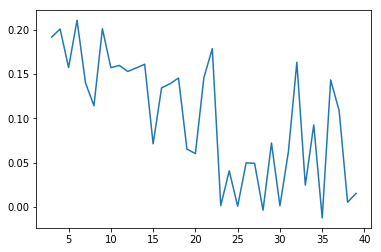

In [244]:
START = 3
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(combined_for_clustering)
    
    scores.append(metrics.silhouette_score(combined_for_clustering, kmeans.labels_))   
kclusters=np.argmax(scores)+START
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
plt.plot(range(START,END),scores)

Hmm, it seems our model won't be really accurate. The best K is 6, however it creats a single "useful" cluster and a lot of clusters with a single row.
There is a another peak in the 30-35 area, so let's zoom there.

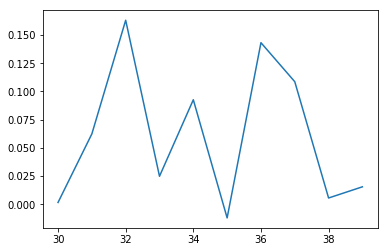

In [245]:
plt.plot(range(30,40),scores[27:37])

More clusters is better in our case, so let's go for 36.

In [246]:
kclusters = 36
kmeans = KMeans(n_clusters=kclusters).fit(combined_for_clustering)
combined_sorted.insert(0, 'Cluster',kmeans.labels_ )

Let's examine our clusters and check if they accomadiate our goal:

In [281]:
combined_sorted.groupby(['Cluster','City']).count()

Neighbourhood  1th Most Common Venue  2th Most Common Venue  \
Cluster City                                                                   
0       London               1                      1                      1   
1       London              16                     16                     16   
        NY                   3                      3                      3   
        Toronto              2                      2                      2   
2       London               3                      3                      3   
3       London              38                     38                     38   
        NY                  37                     37                     37   
        Toronto             28                     28                     28   
4       London              13                     13                     13   
        Toronto              1                      1                      1   
5       London               1                      1                      1   
6       London               4                      4                      4   
7       London               1                      1                      1   
8       London               1                      1                      1   
9       London              15                     15                     15   
        Toronto              2                      2                      2   
10      London              16                     16                     16   
11      London              11                     11                     11   
        Toronto              1                      1                      1   
12      London               9                      9                      9   
        Toronto              2                      2                      2   
13      London               8                      8                      8   
14      Toronto              1                      1                      1   
15      London               1                      1                      1   
        Toronto              1                      1                      1   

                 3th Most Common Venue  4th Most Common Venue  \
Cluster City                                                    
0       London                       1                      1   
1       London                      16                     16   
        NY                           3                      3   
        Toronto                      2                      2   
2       London                       3                      3   
3       London                      38                     38   
        NY                          37                     37   
        Toronto                     28                     28   
4       London                      13                     13   
        Toronto                      1                      1   
5       London                       1                      1   
6       London                       4                      4   
7       London                       1                      1   
8       London                       1                      1   
9       London                      15                     15   
        Toronto                      2                      2   
10      London                      16                     16   
11      London                      11                     11   
        Toronto                      1                      1   
12      London                       9                      9   
        Toronto                      2                      2   
13      London                       8                      8   
14      Toronto                      1                      1   
15      London                       1                      1   
        Toronto                      1                      1   

                 5th Most Common Venue  6th Most Common Venue  \
Cluster City                       

It looks like partial success.
We have several clusters that can be useful becuase they contain neighberhoods from diffrent cities.
The other clusters that contain a single neighberhood can be classified as unsuitable for our model, since they don't have an analogue in other cities.
Let's check the interesting clusters:

In [260]:
useful_clusters = (0,1,11,14,16,33)

In [280]:
#Cluster 1
combined_sorted.loc[combined_sorted['Cluster'] == 1, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
2,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Restaurant,Toronto
3,"CN Tower, Bathurst Quay, Harbourfront West, Is...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry,Toronto
40,Central Harlem,Cosmetics Shop,African Restaurant,Art Gallery,French Restaurant,Seafood Restaurant,Gym / Fitness Center,Public Art,Chinese Restaurant,American Restaurant,Event Space,NY
42,Chinatown,Chinese Restaurant,American Restaurant,Cocktail Bar,Bubble Tea Shop,Spa,Dumpling Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant,Jewelry Store,NY
68,Stuyvesant Town,Park,Bar,Playground,Boat or Ferry,Pet Service,Baseball Field,Fountain,Harbor / Marina,Cocktail Bar,Coffee Shop,NY
81,"Addington, London",Bus Station,Tram Station,Gas Station,English Restaurant,Flea Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,London
104,"Charlton, London",Discount Store,Platform,Food Truck,Furniture / Home Store,Soccer Stadium,Chinese Restaurant,Thai Restaurant,Park,Fast Food Restaurant,Convenience Store,London
110,"Cranford, London",Bus Stop,Fast Food Restaurant,Garden Center,Asian Restaurant,Pharmacy,Convenience Store,Pizza Place,Farm,Hotel,Metro Station,London
111,"Crofton, London",Bus Stop,Dance Studio,Construction & Landscaping,Food,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,London
112,"Crystal Palace, London",Platform,Breakfast Spot,Café,Athletics & Sports,Sculpture Garden,Outdoor Sculpture,Track Stadium,Train Station,Gym / Fitness Center,Farm,London


In [275]:
#Cluster 2
combined_sorted.loc[combined_sorted['Cluster'] == 1, combined_sorted.columns[[1] + list(range(5, combined_sorted.shape[1]))]]

,Neighbourhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
2,Business Reply Mail Processing Centre 969 Eastern,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Restaurant,Toronto
3,"CN Tower, Bathurst Quay, Harbourfront West, Is...",Sculpture Garden,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry,Toronto
40,Central Harlem,French Restaurant,Seafood Restaurant,Gym / Fitness Center,Public Art,Chinese Restaurant,American Restaurant,Event Space,NY
42,Chinatown,Bubble Tea Shop,Spa,Dumpling Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant,Jewelry Store,NY
68,Stuyvesant Town,Boat or Ferry,Pet Service,Baseball Field,Fountain,Harbor / Marina,Cocktail Bar,Coffee Shop,NY
81,"Addington, London",English Restaurant,Flea Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,London
104,"Charlton, London",Furniture / Home Store,Soccer Stadium,Chinese Restaurant,Thai Restaurant,Park,Fast Food Restaurant,Convenience Store,London
110,"Cranford, London",Asian Restaurant,Pharmacy,Convenience Store,Pizza Place,Farm,Hotel,Metro Station,London
111,"Crofton, London",Food,Field,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,London
112,"Crystal Palace, London",Athletics & Sports,Sculpture Garden,Outdoor Sculpture,Track Stadium,Train Station,Gym / Fitness Center,Farm,London


In [249]:
#Cluster 3
combined_sorted.loc[combined_sorted['Cluster'] == 11, combined_sorted.columns[[1] + list(range(5, combined_sorted.shape[1]))]]

,Neighbourhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
7,Christie,Convenience Store,Nightclub,Baby Store,Diner,Restaurant,Italian Restaurant,Athletics & Sports,Toronto
87,"Barnes, London",Restaurant,Pizza Place,Rugby Pitch,Community Center,Coffee Shop,Food & Drink Shop,Nature Preserve,London
90,"Bell Green, London",Supermarket,Gas Station,Chinese Restaurant,Shopping Plaza,Fast Food Restaurant,Clothing Store,Coffee Shop,London
104,"Charlton, London",Furniture / Home Store,Soccer Stadium,Chinese Restaurant,Thai Restaurant,Park,Fast Food Restaurant,Convenience Store,London
108,"Cowley, London",Pub,Park,Flower Shop,Field,Film Studio,Fish & Chips Shop,Fish Market,London
123,"Fish Island, London",Café,Nightclub,Canal Lock,Burger Joint,Event Space,Food & Drink Shop,Theater,London
134,"Harrow, London",Rock Climbing Spot,Supermarket,Warehouse Store,Convenience Store,Fish Market,Fast Food Restaurant,Field,London
151,"Manor House, London",Trail,Pizza Place,Organic Grocery,Park,Gym,Baseball Field,Gym / Fitness Center,London
162,"Northfields, London",Café,French Restaurant,Cheese Shop,Indian Restaurant,Kebab Restaurant,Deli / Bodega,Pub,London
181,"South Acton, London",Grocery Store,Park,Fish & Chips Shop,Pizza Place,Museum,Fast Food Restaurant,Indian Restaurant,London


In [251]:
#Cluster 4
combined_sorted.loc[combined_sorted['Cluster'] == 14, combined_sorted.columns[[1] + list(range(5, combined_sorted.shape[1]))]]

,Neighbourhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
1,"Brockton, Parkdale Village, Exhibition Place",Burrito Place,Stadium,Bar,Caribbean Restaurant,Restaurant,Italian Restaurant,Climbing Gym,Toronto
4,"Cabbagetown, St. James Town",Bakery,Italian Restaurant,Restaurant,Pub,Pizza Place,Sandwich Place,Butcher,Toronto
5,Central Bay Street,Burger Joint,Sandwich Place,Bubble Tea Shop,Salad Place,Chinese Restaurant,Sushi Restaurant,Sculpture Garden,Toronto
9,"Commerce Court, Victoria Hotel",Restaurant,American Restaurant,Steakhouse,Bakery,Gastropub,Seafood Restaurant,Italian Restaurant,Toronto
13,"First Canadian Place, Underground city",Bar,Gastropub,Burger Joint,Restaurant,Seafood Restaurant,Deli / Bodega,Bakery,Toronto
16,"Harbourfront East, Toronto Islands, Union Station",Italian Restaurant,Café,Scenic Lookout,Restaurant,Bakery,Brewery,Pizza Place,Toronto
22,"North Midtown, The Annex, Yorkville",Pizza Place,Pharmacy,Indian Restaurant,Cosmetics Shop,Pub,Donut Shop,Burger Joint,Toronto
25,"Regent Park, Harbourfront",Mexican Restaurant,Pub,Breakfast Spot,Café,Theater,Gym / Fitness Center,Health Food Store,Toronto
30,St. James Town,Hotel,Cosmetics Shop,Breakfast Spot,Bakery,Clothing Store,Gastropub,Cocktail Bar,Toronto
31,Stn A PO Boxes 25 The Esplanade,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Beer Bar,Hotel,Park,Bakery,Toronto


In [254]:
#Cluster 5
combined_sorted.loc[combined_sorted['Cluster'] == 16, combined_sorted.columns[[1] + list(range(5, combined_sorted.shape[1]))]]

,Neighbourhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
27,Rosedale,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Toronto
164,"Northwood, London",Soccer Field,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Zoo Exhibit,London


In [255]:
#Cluster 6
combined_sorted.loc[combined_sorted['Cluster'] == 33, combined_sorted.columns[[1] + list(range(5, combined_sorted.shape[1]))]]

,Neighbourhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
11,Davisville North,Hotel,Breakfast Spot,Sandwich Place,Clothing Store,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Toronto
29,"South Hill, Summerhill West, Forest Hill SE, D...",American Restaurant,Liquor Store,Sports Bar,Supermarket,Bagel Shop,Sushi Restaurant,Fried Chicken Joint,Toronto
35,The Beaches,Grocery Store,Pub,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Toronto
78,"Acton Green, London",Grocery Store,Wine Shop,Gym / Fitness Center,Park,Train Station,Bakery,Convenience Store,London
84,"Archway, London",Italian Restaurant,Bar,Café,Indian Restaurant,Hotel,Gym / Fitness Center,Gastropub,London
86,"Barking, London",Gym,Coffee Shop,Pub,Portuguese Restaurant,Hotel,Steakhouse,Fast Food Restaurant,London
98,"Bow, London",Grocery Store,Chinese Restaurant,Gift Shop,Bar,Bakery,Fish & Chips Shop,Turkish Restaurant,London
99,"Broad Green, London",Coffee Shop,Pizza Place,Sri Lankan Restaurant,Indian Restaurant,Doner Restaurant,Farmers Market,Food Truck,London
114,"Cyprus, London",Bar,Coffee Shop,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,London
128,"Gordon Hill, London",Indian Restaurant,Pizza Place,Grocery Store,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,London
